## Sentiment analysis using a Recurrent Neural Network with Long Short Term memory nets

In [1]:
import os

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from collections import Counter
from sklearn.metrics import roc_curve, auc

# Run these if you cannot import the nltk libs.
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

In [4]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import tensorflow.keras.backend as K

In [5]:
tf.__version__ # Install tensorflow-gpu==2.0.0, if it can utilize CUDA

'2.0.0'

#### Load data and create labels based on rating
0=negative
1=neutral
2=positive

In [6]:
reviews = pd.read_csv('data/data.csv', encoding='utf-8')
reviews['sentiment'] = [(2 if rating > 3 else 1 if rating == 3 else 0) for rating in reviews.rating]
reviews['sentiment_binary'] = [(1 if rating > 3 else 0) for rating in reviews.rating]

In [7]:
reviews.head()

,category,cons,language,pros,rating,source,source-category,source-tags,split,tags,content,sentiment,sentiment_binary
0,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],rom s topp inn tvdram akkurat andr sist sesong...,2,1
1,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],twin peaks definitiv gold box edition gull twi...,2,1
2,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],the wir sesong the wir gjør avheng god måt nes...,2,1
3,screen,NaN,nb,NaN,5,p3,tv,[],train,['tv'],mad sesong stil underhold sofistiker tvseri ma...,2,1
4,screen,NaN,nb,NaN,5,p3,film,[],train,['movie'],mad sesong tvunderholdning høyest kvalit først...,2,1


#### Convert to integer sequence, split into test & train

In [8]:
num_words = 25000 # Vocabulary size to consider. (common words)
max_len = 256 # (230) Computed using the avg amount of words -> (int(np.ceil(np.mean([len(r.split()) for r in reviews.content]))))
# currently there are 368281 unique words!

In [9]:
word_to_freq = [k for k, _ in Counter(' '.join(reviews.content).split()).most_common(num_words-1)]
word_to_freq = {word:(i+1) for i, word in enumerate(word_to_freq)}
freq_to_word = {v:k for k,v in word_to_freq.items()}

In [10]:
contents = np.array([[word_to_freq[word] if word in word_to_freq else 0 for word in r.split()] for r in reviews.content]) # Make representation based on frequent words.

In [11]:
[freq_to_word[n] if n in freq_to_word else '<OOV>' for n in contents[0]][20:30] # Convert back to words.

['stikk',
 'kjøp',
 'sesong',
 'nem',
 'verd',
 'best',
 'tvseri',
 'sett',
 'fir',
 'først']

#### Split into test & train

In [12]:
def train_test_split(df, content, binary=True):
    """
    Split into train vs test & dev
    """
    idxTrain = [i for i,s in zip(df.index, df.split) if s == 'train']
    idxTestDev = [i for i,s in zip(df.index, df.split) if s != 'train']    
    return content[idxTrain], content[idxTestDev], np.array(df.iloc[idxTrain].sentiment_binary if binary else df.iloc[idxTrain].sentiment), np.array(df.iloc[idxTestDev].sentiment_binary if binary else df.iloc[idxTestDev].sentiment)

In [13]:
trainX, testX, trainY, testY = train_test_split(reviews, contents, False)
trainX_b, testX_b, trainY_b, testY_b = train_test_split(reviews, contents, True)

In [14]:
print(len(trainY), '---', len(testY))

34903 --- 8711


#### Train using multiple labels

In [40]:
trainX = tf.keras.preprocessing.sequence.pad_sequences(trainX, maxlen=max_len)
testX = tf.keras.preprocessing.sequence.pad_sequences(testX, maxlen=max_len)

In [54]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(num_words, 100, input_shape=(trainX.shape[1],)))
model.add(tf.keras.layers.LSTM(units=25, activation='tanh', dropout=0.2))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 100)          2500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                12600     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 78        
Total params: 2,512,678
Trainable params: 2,512,678
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
model.fit(trainX, trainY, epochs=5, batch_size=64)

Train on 30529 samples
Epoch 1/5
30529/30529 [==============================] - 29s 934us/sample - loss: 0.6119 - accuracy: 0.7593
Epoch 2/5
30529/30529 [==============================] - 27s 884us/sample - loss: 0.4956 - accuracy: 0.7956
Epoch 3/5
30529/30529 [==============================] - 26s 862us/sample - loss: 0.4421 - accuracy: 0.8187
Epoch 4/5
30529/30529 [==============================] - 28s 933us/sample - loss: 0.3948 - accuracy: 0.8437
Epoch 5/5
30529/30529 [==============================] - 27s 895us/sample - loss: 0.3484 - accuracy: 0.8648


In [57]:
loss, accuracy = model.evaluate(testX, testY, verbose=0)
print(loss, accuracy)

0.5091904757266105 0.8011463


#### Train using binary sentiments

In [15]:
trainX_b = tf.keras.preprocessing.sequence.pad_sequences(trainX_b, maxlen=max_len)
testX_b = tf.keras.preprocessing.sequence.pad_sequences(testX_b, maxlen=max_len)

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(num_words, 100, input_shape=(trainX_b.shape[1],)))
model.add(tf.keras.layers.LSTM(units=100, activation='tanh', dropout=0.2))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 100)          2500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,580,501
Trainable params: 2,580,501
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(trainX_b, trainY_b, epochs=5, batch_size=64)

In [44]:
loss, accuracy = model.evaluate(testX_b, testY_b, verbose=0)
print(loss, accuracy)

0.45621206589586916 0.8411158


#### Running predictions on new reveiws

In [45]:
word_stemmer = SnowballStemmer("norwegian", ignore_stopwords=False)
excludedStopWords = set(['ikkje', 'ikke', 'inkje'])
stopWords = set([word for word in set(stopwords.words('norwegian')) if word not in excludedStopWords])
def predictReview(text, mdl):
    text = text.strip().lower()
    text = re.sub(r'[^a-zæøåéäö ]+', '', text) # Remove any symbols
    text = re.sub(r'\s\s+', ' ', text) # Remove consequent whitespace    
    text = ' '.join([word_stemmer.stem(word) for word in word_tokenize(text) if word not in stopWords])
    encoded = np.array([[word_to_freq[word] if word in word_to_freq else 0 for word in text.split()]])
    return int(mdl.predict_classes(tf.keras.preprocessing.sequence.pad_sequences(encoded, maxlen=max_len))[0])

In [46]:
test_reviews = [
    'dÅrlig film! får lyst til å spy!',
    'ikke dårlig!',
    'den trenger litt finpuss men ellers helt fin',
    'den falt ikke i min smak, håper på at sesong 3 blir bedre',
    'det kan ikke bli værre musikk en dette her',
]

In [47]:
[predictReview(review, model) for review in test_reviews] # TODO, review 2 context is not considered?

[0, 0, 1, 0, 0]

#### ROC, AUC Plot for binary classification

In [48]:
predicted_labels = model.predict_classes(testX_b)

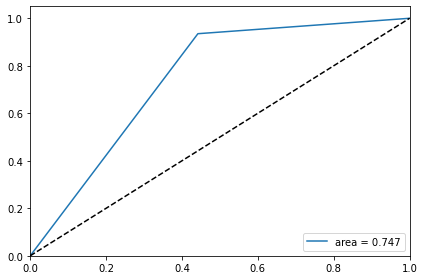

In [51]:
fpr,tpr,_ = roc_curve(testY_b, predicted_labels)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.3f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./img/auc_rnn_binary_lstm', transparent=False, bbox_inches='tight')
plt.show()

#### Run with multiple params

In [14]:
HP_OPTIMIZER = ['adam', 'rmsprop']
HP_NUM_UNITS = [25, 50, 100]
HP_BATCH_SIZE = [64, 128, 256]
HP_DROPOUT = [0, 0.1, 0.2]
HP_LEARNING_RATE = [0.001, 0.003, 0.01, 0.1]

In [44]:
COLUMNS = ['Acc', 'Loss', 'Opt', 'Batch', 'Units', 'Dropout', 'LearnRate']

def getOptimizer(opt, rate):
    return (tf.keras.optimizers.Adam(learning_rate=rate) if opt == 'adam' else tf.keras.optimizers.RMSprop(learning_rate=rate))

def run_model_complex(train_x, train_y, test_x, test_y, vocabulary, binary=False, embedding_size=100, verbose=True):
    K.clear_session()
    numIter = 1
    results = []
    
    for opt in HP_OPTIMIZER:
        for batch in HP_BATCH_SIZE:
            for unit in HP_NUM_UNITS:
                for dropout in HP_DROPOUT:
                    for learn_rate in HP_LEARNING_RATE:
                        model = tf.keras.Sequential()
                        model.add(tf.keras.layers.Embedding(vocabulary, embedding_size, input_shape=(train_x.shape[1],)))
                        model.add(tf.keras.layers.LSTM(units=unit, activation='tanh', dropout=dropout))
                        model.add(tf.keras.layers.Dense(units=1 if binary else 3, activation='sigmoid' if binary else 'softmax'))
                        model.compile(optimizer=getOptimizer(opt, learn_rate), loss='binary_crossentropy' if binary else 'sparse_categorical_crossentropy', metrics=['accuracy'])
                        model.fit(train_x, train_y, epochs=3, batch_size=batch, verbose=0)
                        loss, accuracy = model.evaluate(test_x, test_y, verbose=0)                        
                        results.append([accuracy, loss, opt, batch, unit, dropout, learn_rate])
                        if verbose and ((numIter % 4) == 0):
                            print(numIter, "Processed ---> {:.3f} LOSS, {:.3f} ACCU".format(loss, accuracy))
                        numIter += 1
                        K.clear_session()
                        model = None
                            
    results.sort(key = lambda x: x[1]) # Sort on LOSS, low->high
    return results

def createDataFrameForResults(res):
    data = np.array(res)
    df = pd.DataFrame()
    for i, c in enumerate(COLUMNS):
        df[c] = data[:,i]    
    return df

In [45]:
#res1 = run_model_complex(trainX, trainY, testX, testY, num_words) # Takes approx 4hr and 20min avg 1.2 min per iteration

In [46]:
#res2 = run_model_complex(trainX_b, trainY_b, testX_b, testY_b, num_words, True)

In [47]:
#df1 = createDataFrameForResults(res1)
#df1.to_csv ('./params/rnn_multi_params.csv', index=False, header=False)

In [48]:
#df2 = createDataFrameForResults(res2)
#df2.to_csv ('./params/rnn_binary_params.csv', index=False, header=False)

#### Load result params

In [49]:
for obj in sorted(pd.read_csv('./params/rnn_multi_params.csv', names=COLUMNS).values.tolist(), key=lambda x:x[0], reverse=True):
    print("{:.4},{:.4},{},{},{},{},{}".format(obj[0], obj[1], obj[2], obj[3], obj[4], obj[5], obj[6]))

0.7981,0.522,rmsprop,64,100,0.0,0.003
0.7979,0.612,rmsprop,64,50,0.1,0.003
0.7957,0.617,rmsprop,64,25,0.2,0.01
0.795,0.5395,rmsprop,64,50,0.2,0.001
0.7943,0.544,rmsprop,64,100,0.2,0.01
0.7937,0.5354,rmsprop,64,100,0.1,0.003
0.7924,0.5842,rmsprop,128,100,0.2,0.01
0.792,0.5382,rmsprop,64,25,0.0,0.003
0.792,0.5994,rmsprop,64,25,0.0,0.01
0.7915,0.5528,rmsprop,64,100,0.1,0.01
0.7912,0.5381,rmsprop,128,50,0.2,0.001
0.7911,0.518,rmsprop,64,100,0.1,0.001
0.7908,0.5127,rmsprop,64,25,0.2,0.001
0.7895,0.5503,rmsprop,64,50,0.1,0.01
0.7894,0.583,rmsprop,128,100,0.1,0.01
0.789,0.5228,rmsprop,64,25,0.2,0.003
0.7888,0.5952,rmsprop,128,25,0.2,0.01
0.7888,0.5439,rmsprop,128,100,0.1,0.001
0.7885,0.5629,rmsprop,128,100,0.2,0.003
0.7883,0.6587,rmsprop,64,50,0.0,0.01
0.7879,0.5326,rmsprop,128,50,0.0,0.001
0.7877,0.5765,rmsprop,64,50,0.0,0.003
0.7874,0.6283,rmsprop,256,50,0.0,0.001
0.7871,0.5331,rmsprop,64,100,0.0,0.001
0.7864,0.6251,rmsprop,256,100,0.2,0.01
0.7864,0.6793,adam,128,100,0.2,0.01
0.7861,0.5743,

In [50]:
for obj in sorted(pd.read_csv('./params/rnn_binary_params.csv', names=COLUMNS).values.tolist(), key=lambda x:x[0], reverse=True):
    print("{:.4},{:.4},{},{},{},{},{}".format(obj[0], obj[1], obj[2], obj[3], obj[4], obj[5], obj[6]))

0.8513,0.4058,rmsprop,64,100,0.1,0.003
0.8488,0.3615,rmsprop,64,100,0.2,0.001
0.8484,0.3901,rmsprop,64,50,0.2,0.001
0.8471,0.3911,rmsprop,64,50,0.2,0.003
0.8459,0.3625,rmsprop,128,100,0.2,0.01
0.8455,0.4079,rmsprop,128,50,0.2,0.01
0.8449,0.3873,rmsprop,64,25,0.1,0.003
0.8446,0.4043,rmsprop,64,100,0.1,0.01
0.8445,0.3934,rmsprop,64,50,0.1,0.01
0.8445,0.4042,rmsprop,128,50,0.2,0.001
0.8442,0.4353,rmsprop,64,50,0.0,0.01
0.843,0.4505,rmsprop,64,100,0.2,0.003
0.8426,0.3887,rmsprop,128,50,0.0,0.001
0.8424,0.3795,rmsprop,128,100,0.0,0.003
0.8422,0.5058,rmsprop,64,50,0.2,0.01
0.8421,0.3676,rmsprop,128,100,0.1,0.003
0.842,0.412,rmsprop,128,100,0.0,0.01
0.8418,0.3858,rmsprop,64,50,0.0,0.003
0.8414,0.3857,rmsprop,128,100,0.1,0.01
0.8413,0.3918,rmsprop,128,25,0.2,0.01
0.8407,0.3771,rmsprop,128,25,0.2,0.001
0.8405,0.4197,rmsprop,256,100,0.1,0.01
0.8403,0.3893,rmsprop,64,25,0.1,0.001
0.8397,0.4161,rmsprop,128,100,0.0,0.001
0.8391,0.4368,rmsprop,128,25,0.1,0.01
0.8382,0.4886,rmsprop,64,100,0.2,0.01
0.